In [1]:
from MatlabFuncs import *
from model import *
from triangle import *
from bamg import bamg
from savevars import *
import plotdoc
from loadmodel import *
import os
from os.path import exists

from export_netCDF import export_netCDF

from scipy.io import loadmat
from m1qn3inversion import *
import numpy as np
from ContourToNodes import *
from solve import *

#import lhsmdu #install in terminal 'pip install lhsmdu'
import matplotlib.pyplot as plt
import pickle

import numpy as np
from osgeo import gdal
from matplotlib import pyplot as plt

from InterpFromGridToMesh import InterpFromGridToMesh
from InterpFromMeshToMesh2d import InterpFromMeshToMesh2d

import copy
import utilities
from reinitializelevelset import *

In [2]:
# Setup
cluster_username = 'mpascual'


In [4]:
md = loadmodel('/efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_Param_m2.0.nc')

###################################
## set the inversion parameters ##
###################################
## Inversion
print('Setting up the inversion')
# Control general
md.inversion=m1qn3inversion(md.inversion)
md.inversion.iscontrol=1
md.verbose.solution = False
md.verbose.control = True
md.verbose.qmu = False

# Cost functions
print(' -> Setting cost function values')
md.inversion.cost_functions=[101, 103, 501]; #Abs, Log, reg
md.inversion.cost_functions_coefficients=np.ones([md.mesh.numberofvertices,len(md.inversion.cost_functions)])
md.inversion.cost_functions_coefficients[:,0]=2000
md.inversion.cost_functions_coefficients[:,1]=40
md.inversion.cost_functions_coefficients[:,2]=1.6e-06

# Where vel==0, set coefficients to 0 (i.e., don't try to match this in model)
print(' -> Removing vel==0 obs from inversion')
pos = md.inversion.vel_obs == 0
md.inversion.cost_functions_coefficients[pos,0] = 0
md.inversion.cost_functions_coefficients[pos,1] = 0

# Controls
print(' -> Setting control parameters')
md.inversion.control_parameters=['FrictionCoefficient']
md.inversion.maxsteps=50
md.inversion.maxiter =100
md.inversion.min_parameters=0.05*np.ones(md.mesh.numberofvertices)
md.inversion.max_parameters=np.nan*np.ones(md.mesh.numberofvertices)
md.inversion.control_scaling_factors=1

# Additional parameters
md.stressbalance.restol=0.01
md.stressbalance.reltol=0.1
md.stressbalance.abstol=np.nan
#md.stressbalance.requested_outputs={'default','DeviatoricStressxx','DeviatoricStressyy','DeviatoricStressxy'}

md.friction.coupling = 2

print('')

    
#set ice rheology
from cuffey import cuffey 
#Vary Celsius range with LHS
temperature = -10 + (-10*0.5) #(-15 = cold, -1 = warm)
# convert celsius to kelvin
temperature = temperature + 273.15 
#Calculate rigidity
rigidity = cuffey(temperature)
#Set rigidity calculation to rheology
md.materials.rheology_B = rigidity
    
####################
## run inversion ##
####################
# SMCE pCluster
from eis_nasa_smce import eis_nasa_smce
md.cluster = eis_nasa_smce()
md.cluster.name = 'pcluster.sealevel.eis.smce.nasa.gov'
md.cluster.partition = 'sealevel-c5n18xl-demand'
md.cluster.login = cluster_username
md.cluster.idfile = '~/.ssh/id_rsa'
md.cluster.executionpath = '/efs/' + cluster_username + '/issm_execution_cluster'
md.cluster.numnodes = 1
md.cluster.cpuspernode = 36

md.inversion.iscontrol = 1 
md.settings.waitonlock = np.inf
md = solve(md, 'sb')
    
export_netCDF(md, '/efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_inversion_m2.nc')

Opening /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_Param_m2.0.nc for reading 
group toolkits is empty
group results is empty
Setting up the inversion
converting inversion to m1qn3inversion
 -> Setting cost function values
 -> Removing vel==0 obs from inversion
 -> Setting control parameters

eis_nasa_smce_settings.py not found, using default settings
uploading input file and queueing script
solve.py: launch
launching solution sequence on remote cluster


You are accessing a U.S. Government information system, which includes, 1. this computer, 2. this computer network, 3. all computers connected to this network including end user systems, 4. all devices and storage media attached to this network or to any computer on this network and 5.cloud and remote information services. This information system is provided for U.S. Government-authorized use only. You have no reasonable expectation of privacy regarding any communication transmitted through or data stored on this information system. At any time, and for any lawful purpose, the U.S. Government may monitor, intercept, search, and seize any communication or data transiting, stored on, or traveling to or from this information system. You are NOT authorized to process classified information on this information system. Unauthorized or improper use of this system may result in suspension or loss of access privileges, disciplinary action, and civil and/or criminal penalties.



Submitted batch job 55197
solve.py: launched!
solve.py: waitonlock
waiting for /efs/mpascual/issm_execution_cluster/Greenland-04-13-2023-16-44-10-712/Greenland.lock hold on... (Ctrl+C to exit)
starting while loop
checking for job completion (time: 0 min 5 sec)      


You are accessing a U.S. Government information system, which includes, 1. this computer, 2. this computer network, 3. all computers connected to this network including end user systems, 4. all devices and storage media attached to this network or to any computer on this network and 5.cloud and remote information services. This information system is provided for U.S. Government-authorized use only. You have no reasonable expectation of privacy regarding any communication transmitted through or data stored on this information system. At any time, and for any lawful purpose, the U.S. Government may monitor, intercept, search, and seize any communication or data transiting, stored on, or traveling to or from this information system. You are NOT authorized to process classified information on this information system. Unauthorized or improper use of this system may result in suspension or loss of access privileges, disciplinary action, and civil and/or criminal penalties.



File /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_inversion_m2.nc allready exist


Give a new name or "delete" to replace:  delete


field md.solidearth.external is None
qmu is skipped until it is more stable


In [16]:
md1 = loadmodel('/efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_inversion_m1.nc')
md2 = loadmodel('/efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_inversion_m2.nc')
md_vel_tot = (md1.results.StressbalanceSolution.Vel - md2.results.StressbalanceSolution.Vel)

Opening /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_inversion_m1.nc for reading 
eis_nasa_smce_settings.py not found, using default settings
empty init
Opening /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_inversion_m2.nc for reading 
eis_nasa_smce_settings.py not found, using default settings
empty init


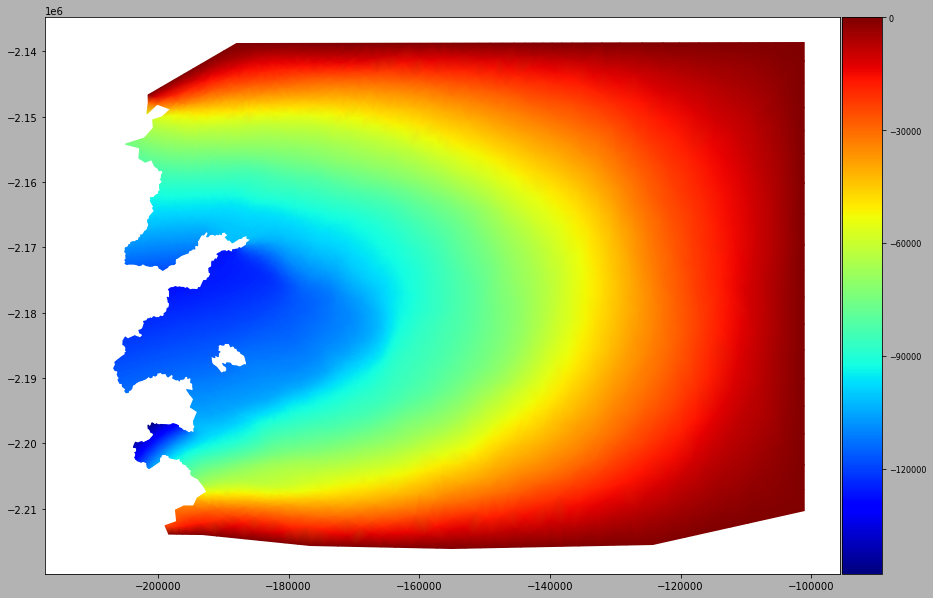

In [10]:
fig = plt.figure(figsize=(15,15))
plotmodel(md1, 'data', md_vel_tot, \
          'mask', md.mask.ice_levelset<0, 'colormap', 'jet')


In [11]:
md = loadmodel('/efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_inversion_m2.nc')

Opening /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_inversion_m2.nc for reading 
eis_nasa_smce_settings.py not found, using default settings
empty init


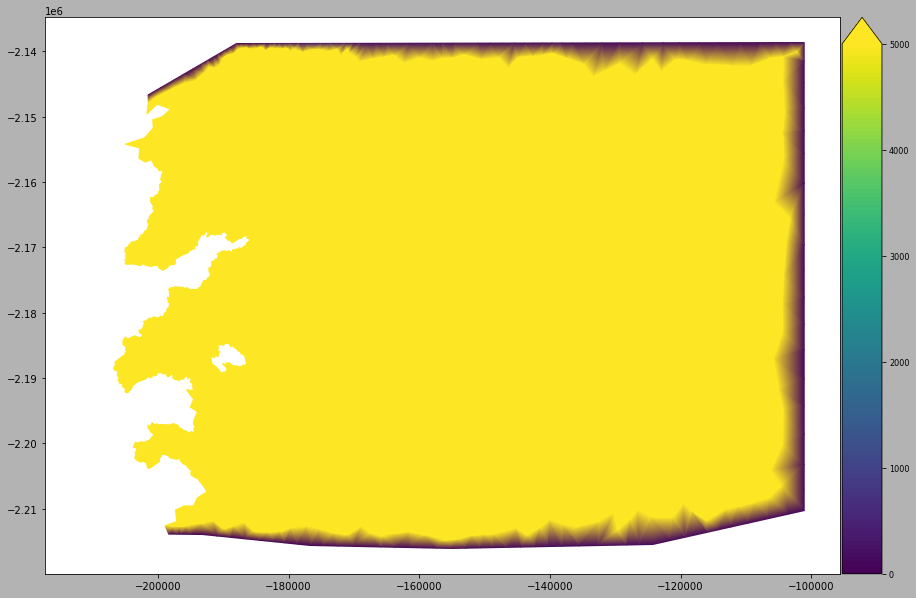

In [20]:
fig = plt.figure(figsize=(15,15))
plotmodel(md1, 'data', md.results.StressbalanceSolution.Vel, \
          'mask', md.mask.ice_levelset<0, 'caxis', [0,5000])


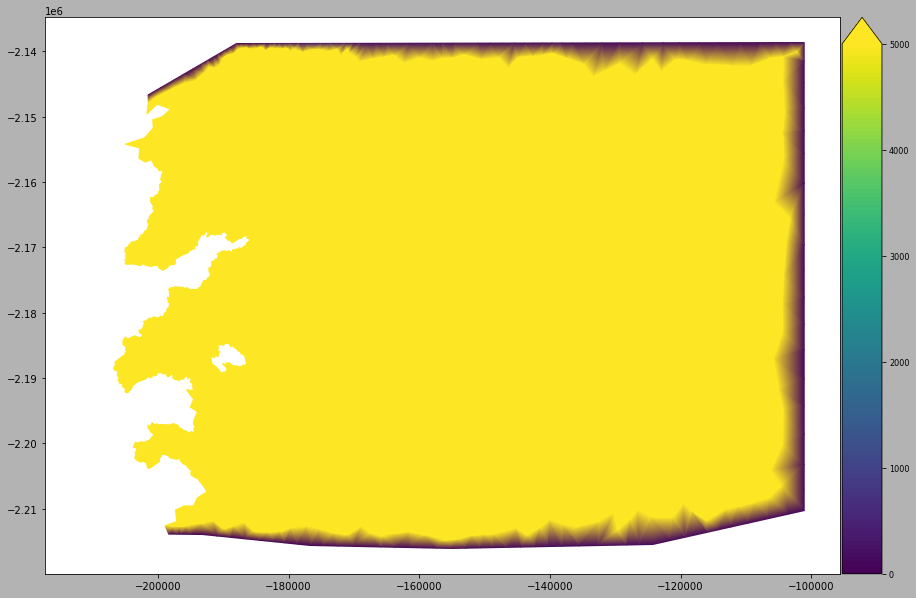

In [19]:
fig = plt.figure(figsize=(15,15))
plotmodel(md2, 'data', md.results.StressbalanceSolution.Vel, \
          'mask', md.mask.ice_levelset<0, 'caxis', [0,5000])


In [21]:
md.results.StressbalanceSolution

    step                            : 0
    time                            : 0
    Adjointx                        : [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.18586936e-09
 6.07777926e-09 1.69929137e-11]
    Adjointy                        : [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -9.95354132e-10
  2.48895376e-09  1.25827328e-11]
    FrictionCoefficient             : [34.96239984  1.          1.         ... 16.31060579 96.47274809
 20.66968629]
    Gradient1                       : [-8.20512296e-05  0.00000000e+00  0.00000000e+00 ... -1.60254053e-03
 -1.16012194e-01 -1.08432932e-05]
    J                               : [[2.56166703e+08 5.46983646e+04 2.08996823e+01 2.56221423e+08]
 [9.46210358e+07 4.65820747e+04 2.11327768e+01 9.46676390e+07]
 [7.87124009e+07 4.53360093e+04 2.12803020e+01 7.87577582e+07]
 [4.84128605e+07 4.20177987e+04 2.21281582e+01 4.84549004e+07]
 [3.38489049e+07 3.95905371e+04 2.35014455e+01 3.38885190e+07]
 [2.24633732e+07 3.68565904e+04 2

In [30]:
md = loadmodel('/efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_inversion_m5.nc')

Opening /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_inversion_m5.nc for reading 
eis_nasa_smce_settings.py not found, using default settings
empty init


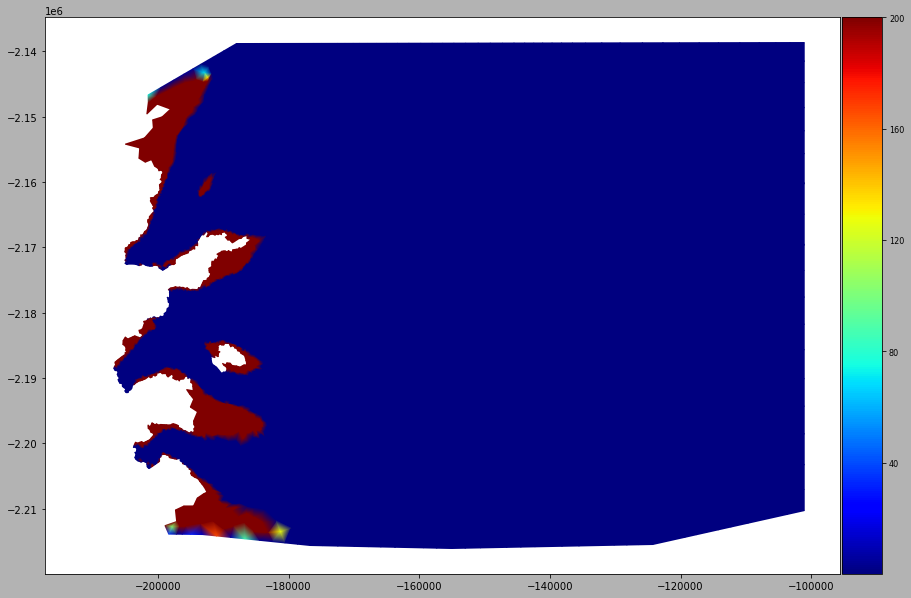

In [31]:
fig = plt.figure(figsize=(15,15))
plotmodel(md, 'data', md.results.StressbalanceSolution.FrictionCoefficient, \
          'mask', md.mask.ice_levelset<0, 'colormap', 'jet')


In [32]:
md = loadmodel('/efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_inversion_m20.nc')

Opening /efs/GrIS_Outlet_Glacier_Seasonal_dhdt/Models/SAtoES_inversion_m20.nc for reading 
eis_nasa_smce_settings.py not found, using default settings
empty init


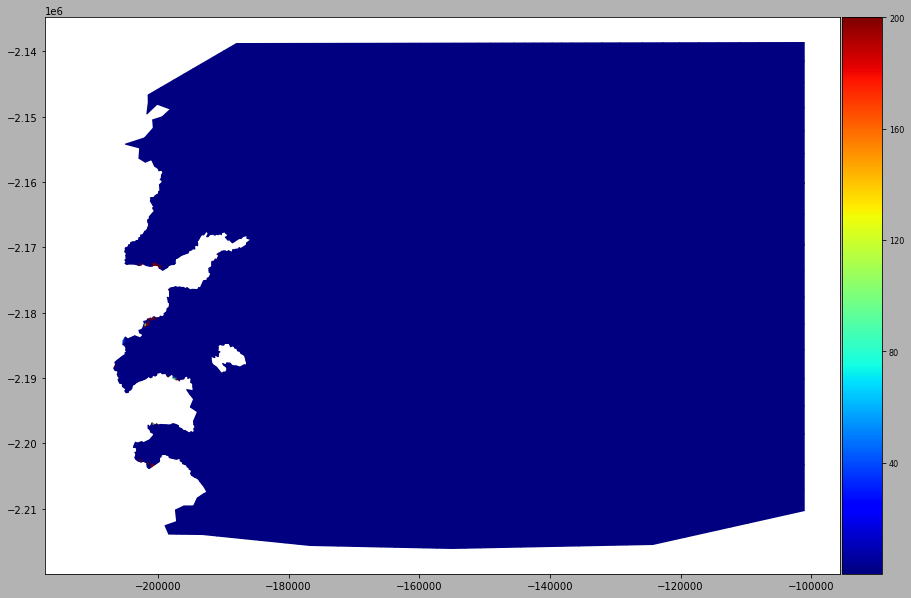

In [33]:
fig = plt.figure(figsize=(15,15))
plotmodel(md, 'data', md.results.StressbalanceSolution.FrictionCoefficient, \
          'mask', md.mask.ice_levelset<0, 'colormap', 'jet')
